In [1]:
import pathlib
import numpy as np

from fytok.Tokamak import Tokamak

from spdm.view import View as sp_view

input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-12-09 17:19:57,659 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-09T17:19:57.353406.
 Job ID: fytok_salmon_surface_4601

###################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion_reaction"}},
            # {"code": {"name": "collisional_equipartition"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "control_parameters": {"bvp_rms_mask": [0.96], "hyper_diff": 0.0001, "max_nodes": 512, "verbose": 2},
            },
        },
        "primary_coordinate": {"label": r"\bar{rho}_{tor_norm}"},
        "equations": [
            # fmt: off
            {"identifier": "ion/D/density",              "profile":  1.0e19,   "boundary_condition": [2, 1]},
            {"identifier": "ion/T/density",              "profile":  1.0e19,   "boundary_condition": [2, 1]},
            # {"identifier": "ion/He/density",             "profile":  0.0,      "boundary_condition": [2, 1]},
            # {"identifier": "ion/alpha/density",          "profile":  0.0,      "boundary_condition": [4, 1]},
            {"identifier": "ion/D/temperature",          "profile":  1000,     "boundary_condition": [4, 1]},
            {"identifier": "ion/T/temperature",          "profile":  1000,     "boundary_condition": [4, 1]},
            # {"identifier": "ion/He/temperature",         "profile":  1000,     "boundary_condition": [2, 1]},
            {"identifier": "electrons/temperature",      "profile":  1000,     "boundary_condition": [4, 1]},
            # fmt: on
        ],
    },
)

2023-12-09 17:19:57,843 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2023-12-09 17:19:58,023 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-12-09 17:19:58,097 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.transport_solver.refresh(
    time=0.0,
    boundary_value=[
        [[0.0], [2.0e19]],      #   n_D
        [[0.0], [2.0e19]],      #   n_T
        # [[0.0], [0.1e19]],    #   n_He
        # [[0.0], [2.0e18]],    #   n_alpha
        [[0.0], [1000]],      #   T_D
        [[0.0], [1000]],      #   T_T
        # [[0.0], [1000]],      #   T_He
        [[0.0], [1000]],        #   T_electron
    ],
)

2023-12-09 17:19:58,142 [    spdm]     INFO: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-12-09 17:19:58,407 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2023-12-09 17:19:58,412 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-09 17:19:58,415 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-09 17:19:58,419 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-09 17:19:58,425 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-09 17:19:58,431 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2023-12-09 17:19:58,436 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2023-12-09 17:19:58,441 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2023-12-09 17:19:58,447 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2023-12-09 17:19:58,451 [    spdm]     INFO: Initialize module fytok.plugins.transport_solv

2023-12-09 17:20:02,877 [    spdm]     INFO: Load module spdm.view.view_matplotlib


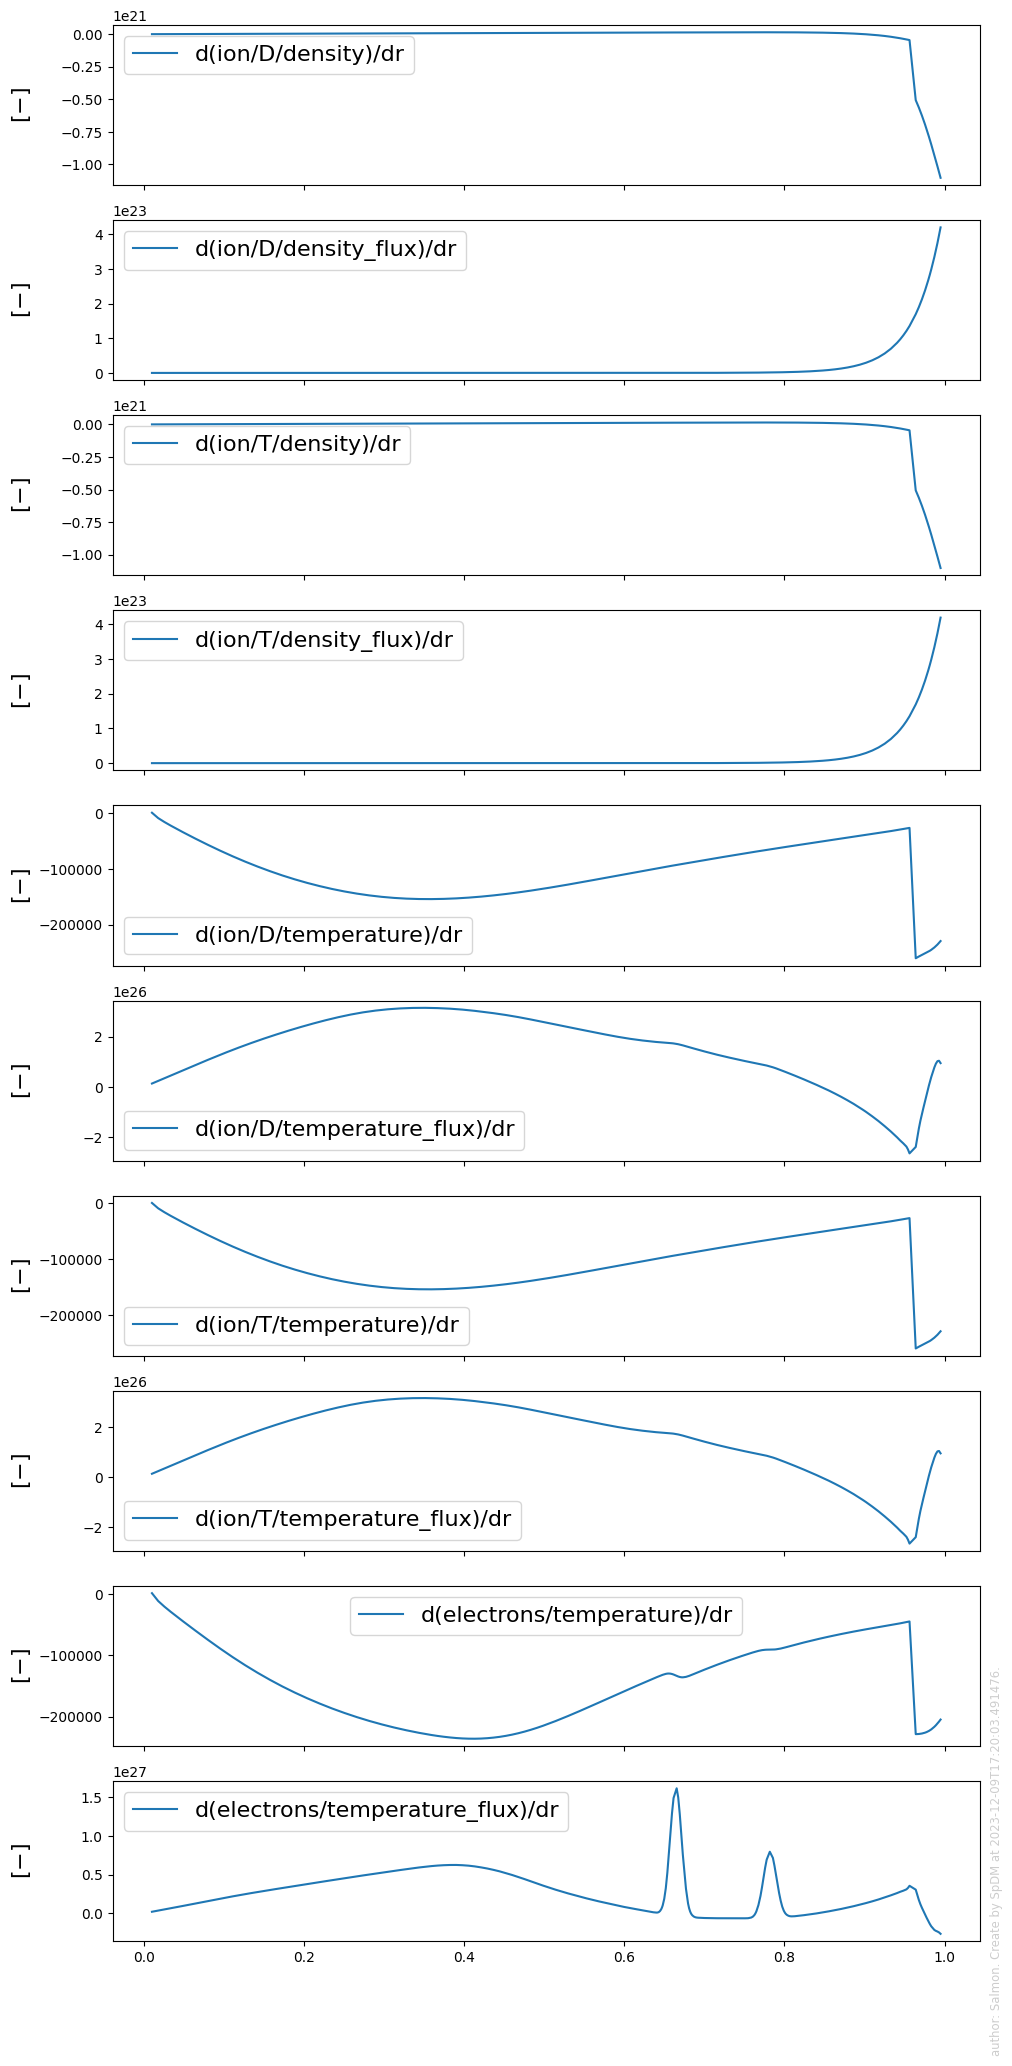

In [4]:
solver_1d = tokamak.transport_solver.time_slice.current
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                (equ.primary_quantity.d_dr, f"d({equ.primary_quantity.identifier})/dr"),
                (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
)

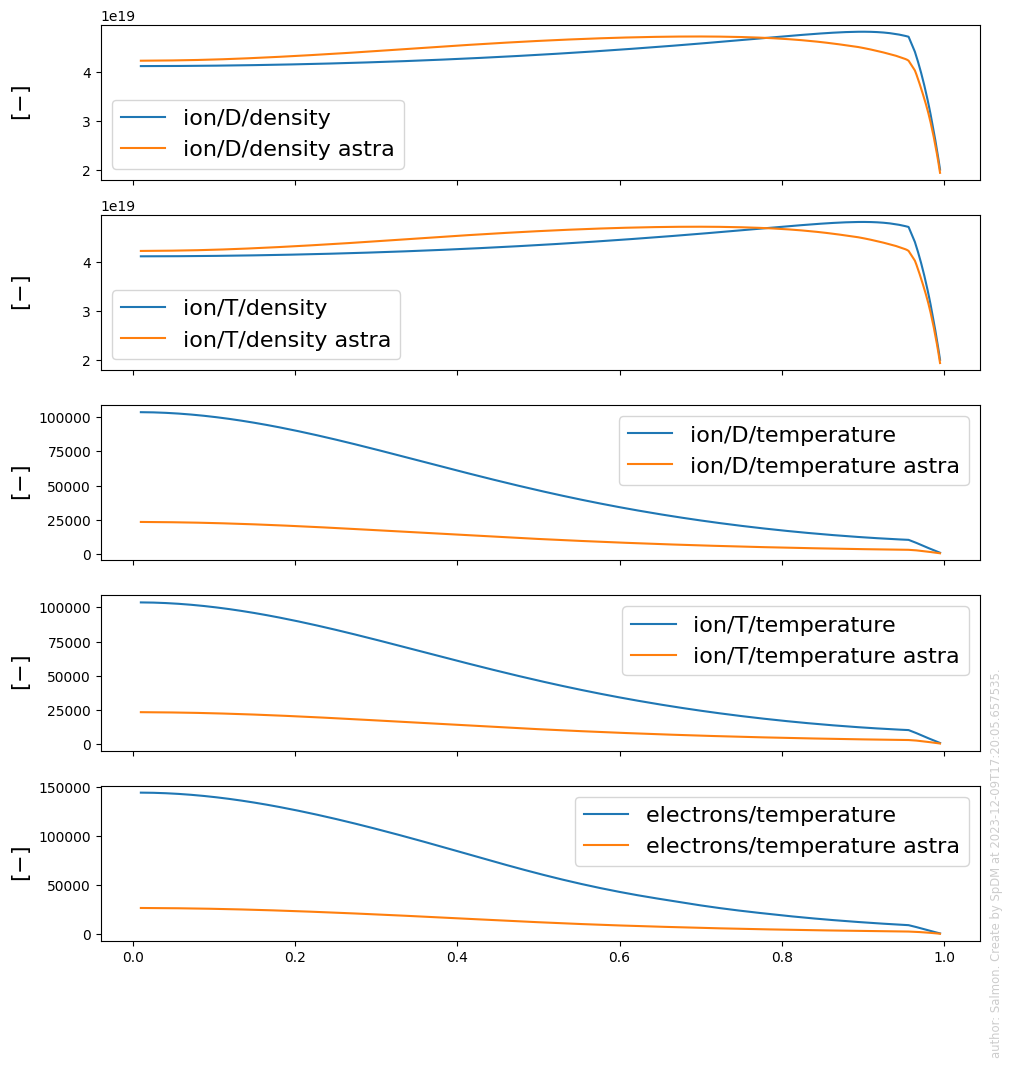

In [5]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *[
        [
            (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier} "),
            (core_profiles_1d.get(equ.primary_quantity.identifier) , rf"{equ.primary_quantity.identifier} astra"),
        ]
        for equ in solver_1d.equation
    ],
)

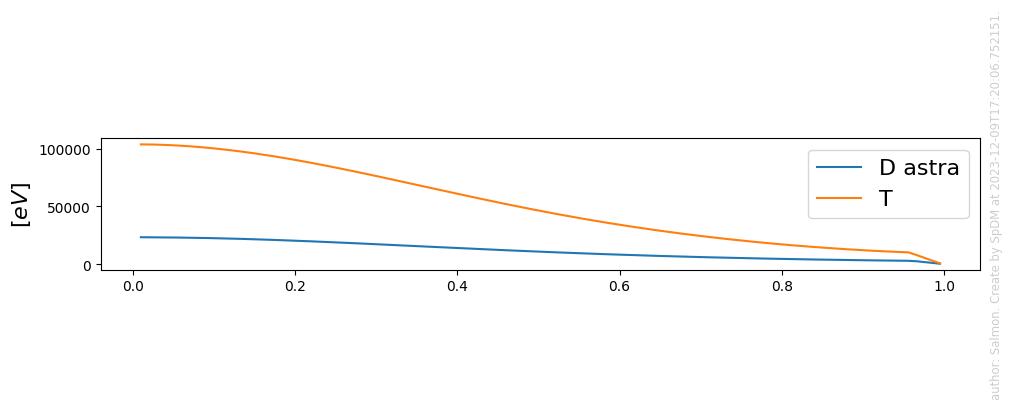

In [6]:

fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [(
        core_profiles_1d.get(solver_1d.equation[2].primary_quantity.identifier, 0) ,
        rf"{solver_1d.equation[2].primary_quantity.identifier.split('/')[-2]} astra",
    ),
    (
        solver_1d.equation[3].primary_quantity.profile ,
        rf"{solver_1d.equation[3].primary_quantity.identifier.split('/')[-2]} ",
    )]
)

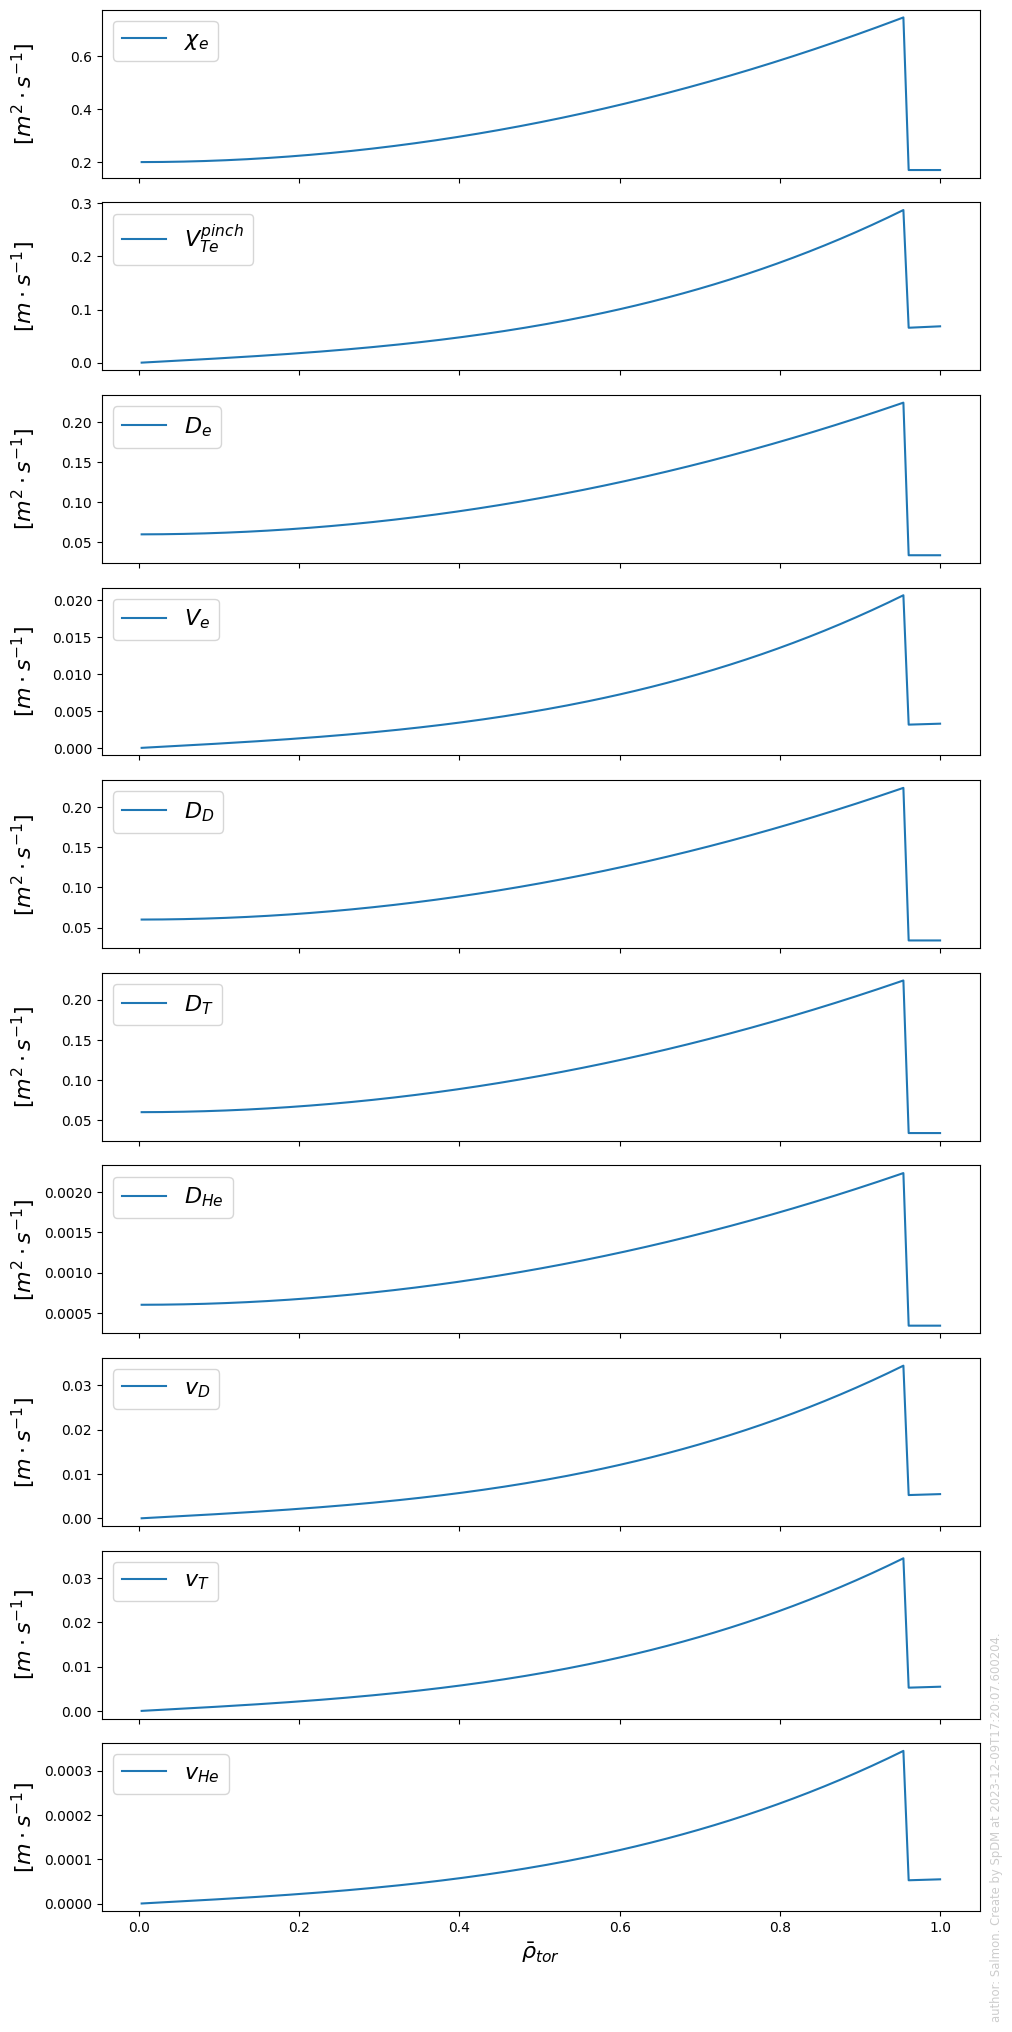

In [7]:
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    core_transport_1d.grid_d.rho_tor_norm,
    (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
    (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
    # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
    # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
    (core_transport_1d.electrons.particles.d, r"$D_e$"),
    (core_transport_1d.electrons.particles.v, r"$V_e$"),
    *[(ion.particles.d, rf"$D_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.particles.v, rf"$v_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    x_label=r"$\bar{\rho}_{tor}$",
)

In [8]:
vars = sum([[equ.primary_quantity.profile, equ.primary_quantity.flux] for equ in solver_1d.equation], [])
equ = solver_1d.equation[3]
(u0, v0, w0), (u1, v1, w1), a, b, c, d, e, f, g = equ.coefficient
x = solver_1d.grid.rho_tor_norm
# y = equ.primary_quantity.profile
# yp = equ.primary_quantity.d_dr
# flux = equ.primary_quantity.flux
# dflux = equ.primary_quantity.dflux_dr
fig = sp_view.plot(
    x,
    (a(x, *vars), "a"),
    (b(x, *vars), "b"),
    # (c(x,*vars), "c"),
    (d(x, *vars), "d"),
    (e(x, *vars), "e"),
    (f(x, *vars), "f"),
    # (g(x, *vars), "g"),
    # tokamak.transport_solver.equations[2].d_dr,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),
    # ],
    # y, yp
    # [
    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
)

ValueError: not enough values to unpack (expected 9, got 8)

In [ ]:
fig = sp_view.plot(
    x,
    solver_1d.equation[1].coefficient[5](x, *vars),
    solver_1d.equation[2].coefficient[5](x, *vars),
    solver_1d.equation[3].coefficient[5](x, *vars),
)

In [ ]:
time_slice = tokamak.core_transport.model[1].fetch(**tokamak.transport_solver.variables)

In [ ]:
time_slice.profiles_1d.ion[0].particles.d
